<a href="https://colab.research.google.com/github/daianagusatu/Artificial-Intelligence/blob/main/18424099_gusatu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from skimage import io
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import regularizers
from keras.datasets import mnist

from keras.utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img

from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, MaxPool2D
from keras.optimizers import Adam, RMSprop, SGD

In [2]:
#Unzip the dataset
!unzip /content/18424099_Emotions_Dataset.zip

Archive:  /content/18424099_Emotions_Dataset.zip
   creating: Test/Anger/
 extracting: Test/Anger/11647173796_033ff06112_n_face.png  
  inflating: Test/Anger/1379351899_7cfa2b0dc4_b_face.png  
  inflating: Test/Anger/14187801814_ea89208940_b_face.png  
  inflating: Test/Anger/22721287949_65572bea8b_n_face.png  
 extracting: Test/Anger/22913025801_2822113219_n_face.png  
  inflating: Test/Anger/2Q__ (1)_face.png  
  inflating: Test/Anger/2Q__ (3)_face.png  
 extracting: Test/Anger/2Q__ (5)_face.png  
 extracting: Test/Anger/2Q___face.png  
  inflating: Test/Anger/8640373691_78da29364a_b_face.png  
  inflating: Test/Anger/9k_ (1)_face.png  
 extracting: Test/Anger/9k_ (2)_face.png  
 extracting: Test/Anger/9k_ (3)_face.png  
  inflating: Test/Anger/9k_ (4)_face.png  
 extracting: Test/Anger/9k_ (5)_face.png  
 extracting: Test/Anger/9k__face.png  
 extracting: Test/Anger/images - 2020-11-05T231347.970_face.png  
  inflating: Test/Anger/images - 2020-11-05T231433.156_face.png  
  inflatin

       Surprise  Happiness  Disgust  Anger  Fear  Neutral  Sadness
Train       350        350      350    310   350      350      369
            Surprise  Happiness  Disgust  Anger  Fear  Neutral  Sadness
Validation       100        100      100    100   100      100      100


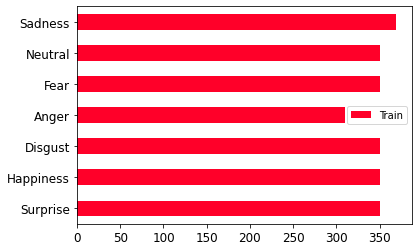

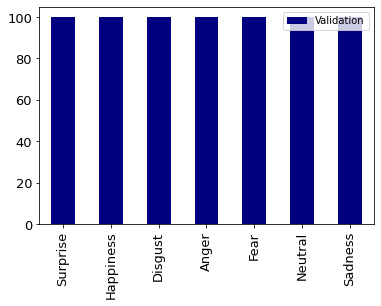

In [3]:
#Print number of images in each folder
trainDir = '/content/Train'
validationDir = '/content/Val/'

#Define the img size and number of classes (folders) present
x, y = 48, 48
emotions = 7

#Count number of pics in each folder per train/val
def printNumDir(path, folder):#Function that returns the number of images in each folder
  arrDir = {}
  for i in os.listdir(path):
    if not i.startswith('.'):
      directory = path + '/' + i
      arrDir[i] = len(os.listdir(directory))
  dsp = pd.DataFrame(arrDir, index=[folder])
  return dsp #Return quantity and labels
xTrain = printNumDir(trainDir, 'Train')
xVal = printNumDir(validationDir, 'Validation')
print(xTrain)#Print count for the Train folder
print(xVal)#Print count for the Validation folder

#Display the valus above in charts
xTrain.transpose().plot(kind='barh', colormap = 'gist_rainbow', fontsize = 12)
xVal.transpose().plot(kind='bar', colormap = 'jet', fontsize = 13)

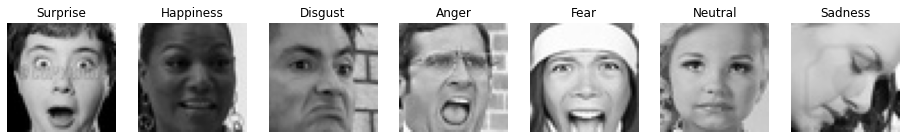

In [4]:
#Display a sample of the images in the training set
plt.figure(figsize=(16,16))#Create a figure 16 by 16
count = 1
for i in os.listdir(trainDir):
  if not i.startswith('.'):
    pic = load_img(trainDir + '/' + i  +'/'+ os.listdir(trainDir + '/' + i)[5])#Get a sample image from each train folder
    plt.subplot(1,7,count)
    plt.imshow(pic)
    plt.title(i)
    plt.axis('off')
    count += 1
plt.show()#Display a figure with the sample images

In [5]:
#Data Augmentation
genTrain = ImageDataGenerator(rescale=1./255, #Images changes and processed before training
                              rotation_range = 40,
                              shear_range = 0.2,
                              zoom_range=0.2,
                              width_shift_range=0.2,
                              height_shift_range=0.2, 
                              horizontal_flip=True)
flowTrain = genTrain.flow_from_directory(trainDir, 
                                         batch_size=20, 
                                         target_size=(48, 48), 
                                         shuffle=True, 
                                         color_mode='grayscale', 
                                         class_mode= 'categorical')


genVal = ImageDataGenerator(rescale=1./255)#Data multiplied with the rescale value
flowVal = genVal.flow_from_directory(validationDir, 
                                     batch_size=20, 
                                     target_size=(48, 48), 
                                     shuffle=True, 
                                     color_mode='grayscale', 
                                     class_mode= 'categorical')

Found 2429 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [6]:
#Prepare the model to be trained
def modelNet(num, emotions=7):
     #Initialising the CNN
    net = tf.keras.models.Sequential()   

    net.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =num))
    net.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    
    net.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    net.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    net.add(BatchNormalization())
    net.add(MaxPooling2D(2, 2))
    net.add(Dropout(0.25))

    net.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    net.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))

    net.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    net.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    net.add(BatchNormalization())
    net.add(MaxPooling2D(2, 2))
    net.add(Dropout(0.25))

    net.add(Flatten())
    net.add(Dense(1024, activation='relu'))
    net.add(Dropout(0.5))
    
    net.add(Dense(emotions, activation='softmax'))

    #Compliling the model
    net.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return net

In [7]:
#Display the summary of the model  
getSummary = modelNet((x, y, 1), emotions)
getSummary.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0

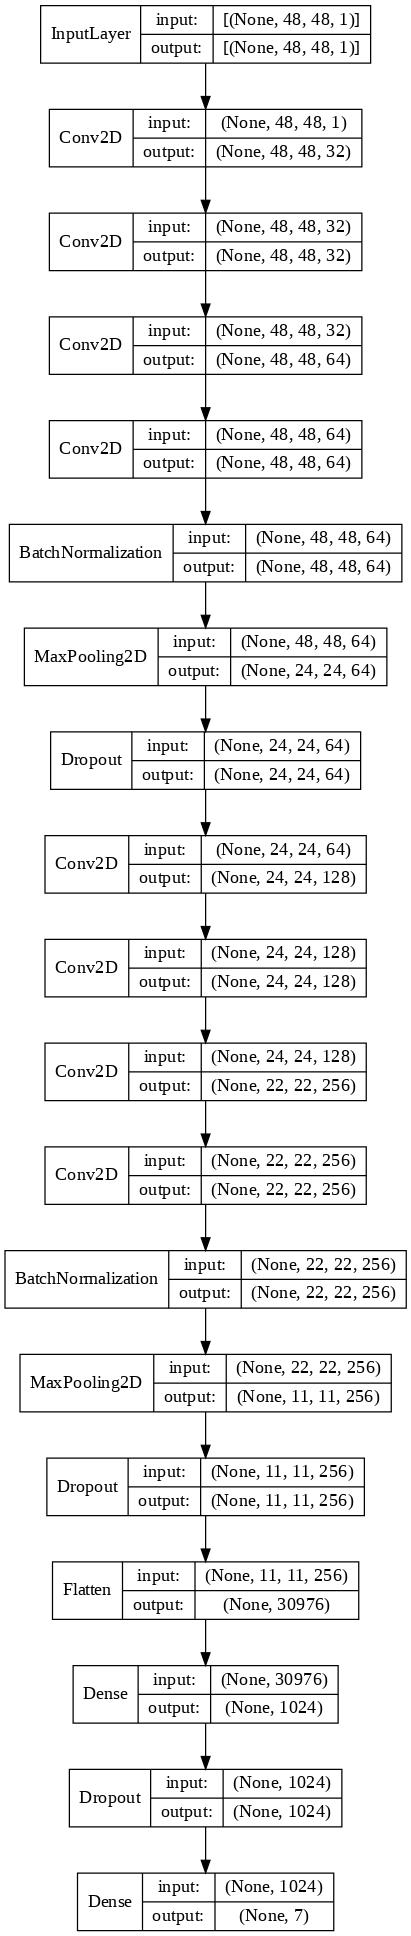

In [8]:
#Convert to dot format and export as jpg
plot_model(getSummary, to_file='/content/summary.jpg', show_shapes = True, rankdir='TB', show_layer_names = False, expand_nested = True, dpi = 90)

In [9]:
#Stop early if loss doesn't improve
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, CSVLogger
path = '/content/summary.h5'
getModelCheckpoint = ModelCheckpoint(filepath = path, save_best_only = True, verbose = 1, mode = 'min', monitor = 'val_loss')
getReduceLRP = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, min_lr=0.0001)
earlyCall = [getModelCheckpoint, getReduceLRP]

epSteps = flowTrain.n // flowTrain.batch_size#Set the amount of training steps available for each epoch
valSteps = flowVal.n // flowVal.batch_size#Set the amount of validation steps available for each epoch
modelTrain = getSummary.fit(x=flowTrain, validation_data=flowVal, epochs=300, steps_per_epoch = epSteps, callbacks = earlyCall, validation_steps = valSteps, shuffle=True, verbose=1)

tf.keras.models.save_model(getSummary, 
                           '/content/', 
                           overwrite=True, 
                           include_optimizer=True, 
                           save_format='tf', 
                           signatures=None)

Epoch 1/300
121/121 [==============================] - 12s 35ms/step - loss: 5.8422 - accuracy: 0.1615 - val_loss: 4.4663 - val_accuracy: 0.1429

Epoch 00001: val_loss improved from inf to 4.46630, saving model to /content/summary.h5
Epoch 2/300
121/121 [==============================] - 4s 30ms/step - loss: 4.3540 - accuracy: 0.1942 - val_loss: 4.4379 - val_accuracy: 0.1429

Epoch 00002: val_loss improved from 4.46630 to 4.43794, saving model to /content/summary.h5
Epoch 3/300
121/121 [==============================] - 4s 30ms/step - loss: 4.1749 - accuracy: 0.2246 - val_loss: 4.4613 - val_accuracy: 0.1429

Epoch 00003: val_loss did not improve from 4.43794
Epoch 4/300
121/121 [==============================] - 4s 30ms/step - loss: 4.0046 - accuracy: 0.2591 - val_loss: 4.2745 - val_accuracy: 0.1429

Epoch 00004: val_loss improved from 4.43794 to 4.27447, saving model to /content/summary.h5
Epoch 5/300
121/121 [==============================] - 4s 30ms/step - loss: 3.8613 - accuracy: 0

In [10]:
getSummary.save('/content/summary.h5')#Save the model activity for prediction

In [11]:
modelTrain.history['accuracy']#Display the accuracy values after training the model

[0.18472395837306976,
 0.2058945596218109,
 0.23578248918056488,
 0.24657534062862396,
 0.25446242094039917,
 0.270236611366272,
 0.2785388231277466,
 0.2793690264225006,
 0.29223743081092834,
 0.31589871644973755,
 0.2955583333969116,
 0.3217102587223053,
 0.33084267377853394,
 0.32752180099487305,
 0.3453715145587921,
 0.3491075038909912,
 0.34661686420440674,
 0.3491075038909912,
 0.3594852685928345,
 0.3565794825553894,
 0.3652968108654022,
 0.39767539501190186,
 0.3955998420715332,
 0.41344955563545227,
 0.43669572472572327,
 0.44748857617378235,
 0.4503943622112274,
 0.46326276659965515,
 0.47779160737991333,
 0.4757160544395447,
 0.4927355647087097,
 0.5097550749778748,
 0.5126608610153198,
 0.5371523499488831,
 0.5276048183441162,
 0.548360288143158,
 0.5421336889266968,
 0.5566624999046326,
 0.5450394153594971,
 0.5628891587257385,
 0.5848900079727173,
 0.5840597748756409,
 0.5815691351890564,
 0.5877957940101624,
 0.5911166667938232,
 0.6044001579284668,
 0.6114570498466492,


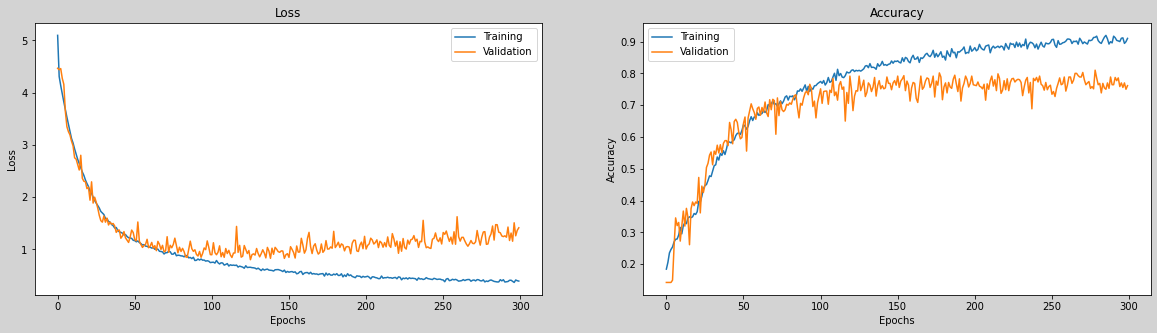

In [12]:
#Create figures that display the history of the model
plt.figure(figsize=(20, 5), edgecolor='b', facecolor='lightgray')

plt.subplot(1, 2, 2)
plt.plot(modelTrain.history['accuracy'])
plt.plot(modelTrain.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.subplot(1, 2, 1)
plt.plot(modelTrain.history['loss'])
plt.plot(modelTrain.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()#Display the figures

In [13]:
#Evaluate both sets
getTrainingLoss, getTrainingAcc = getSummary.evaluate(flowTrain)#Evaluate training values
getValidationLoss, getValidationAcc = getSummary.evaluate(flowVal)#Evaluate validation values
print('Training Accuracy: {:2f}'.format(getTrainingAcc*100))
print('Validation Accuracy: {:2f}'.format(getValidationAcc*100))

35/35 [==============================] - 0s 9ms/step - loss: 1.4138 - accuracy: 0.7614
Training Accuracy: 94.030464
Validation Accuracy: 76.142859


In [14]:
#Display the restored accuracy value based on validation set
dir = '/content/summary.h5'
getSummary = tf.keras.models.load_model(dir, custom_objects = None, compile = True)
loss, accuracy = getSummary.evaluate(flowVal, verbose = 3, batch_size = 64)
getSummary.summary()
print("Restored model, accuracy: {:5.2f}%".format(getValidationAcc*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0

In [15]:
#Creating classification and confusion reports
#Train Set
from sklearn.metrics import classification_report, confusion_matrix
predictTrain = getSummary.predict(flowTrain)
predictTrain = np.argmax(predictTrain, axis=1)
label = flowVal.class_indices
label  = {i:j for j, i in label.items()}

#Display values of the classification report of the training set
confusionMatrix = confusion_matrix(flowTrain.classes, predictTrain)
print('Following the confusion matrix, see the values:')
print(confusionMatrix)
print('The classification seen as below:')
val = list(label.values())
print(classification_report(flowTrain.classes, predictTrain, target_names = val))

Following the confusion matrix, see the values:
[[38 42 46 53 36 50 45]
 [41 51 61 48 45 65 39]
 [42 51 58 39 47 57 56]
 [49 53 54 63 41 53 37]
 [46 52 53 51 39 62 47]
 [44 57 53 61 42 62 50]
 [48 47 56 41 48 68 42]]
The classification seen as below:
              precision    recall  f1-score   support

       Anger       0.12      0.12      0.12       310
     Disgust       0.14      0.15      0.15       350
        Fear       0.15      0.17      0.16       350
   Happiness       0.18      0.18      0.18       350
     Neutral       0.13      0.11      0.12       350
     Sadness       0.15      0.17      0.16       369
    Surprise       0.13      0.12      0.13       350

    accuracy                           0.15      2429
   macro avg       0.14      0.14      0.14      2429
weighted avg       0.14      0.15      0.14      2429



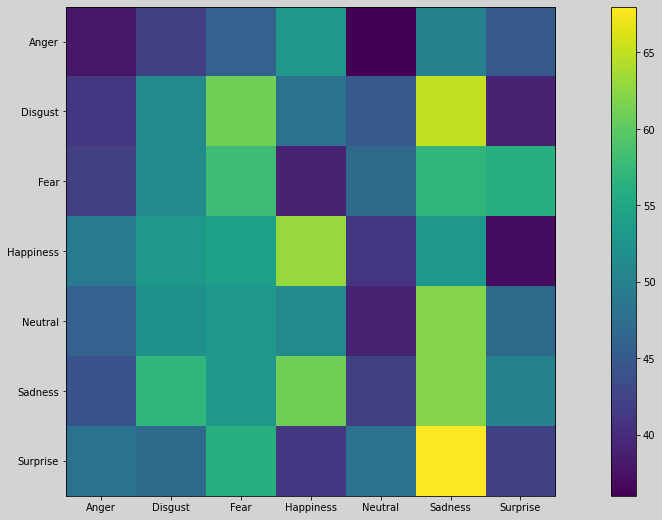

In [16]:
#Heatmap for the confusion matrix - Training
plt.figure(figsize=(20, 9), edgecolor='b', facecolor='lightgray')
plt.imshow(confusionMatrix)
plt.colorbar()
arg = np.arange(len(val))
getXTicks = plt.xticks(arg, val)
getYTicks = plt.yticks(arg, val)

In [17]:
#Validation Set
prediction1 = getSummary.predict(flowVal)
prediction1 = np.argmax(prediction1, axis=1)
label1 = flowVal.class_indices
label1  = {i:j for j, i in label1.items()}

#Display values of the classification report of the validation set
confusionMatrix1 = confusion_matrix(flowVal.classes, prediction1)
print('Following the confusion matrix, see the values:')
print(confusionMatrix1)
print('The classification seen as below:')
val1 = list(label1.values())
print(classification_report(flowVal.classes, prediction1, target_names = val1))

Following the confusion matrix, see the values:
[[19 12 24 14  4 18  9]
 [13 13 27 12  9 13 13]
 [ 7 19 20 19  9 13 13]
 [13 14 19 15 15  8 16]
 [15 18 18 16  8 19  6]
 [15 13 19 14  8 23  8]
 [13 18 18 19  6 12 14]]
The classification seen as below:
              precision    recall  f1-score   support

       Anger       0.20      0.19      0.19       100
     Disgust       0.12      0.13      0.13       100
        Fear       0.14      0.20      0.16       100
   Happiness       0.14      0.15      0.14       100
     Neutral       0.14      0.08      0.10       100
     Sadness       0.22      0.23      0.22       100
    Surprise       0.18      0.14      0.16       100

    accuracy                           0.16       700
   macro avg       0.16      0.16      0.16       700
weighted avg       0.16      0.16      0.16       700



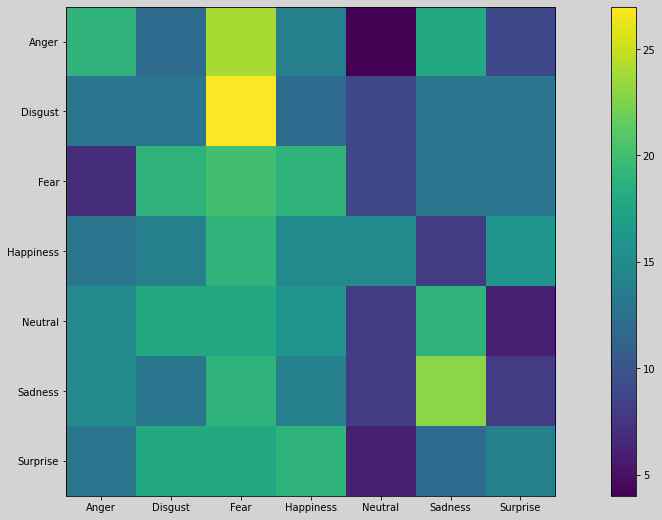

In [18]:
#Hotmap for the confusion matrix - Validation
plt.figure(figsize=(20, 9), edgecolor='b', facecolor='lightgray')
plt.imshow(confusionMatrix1)
plt.colorbar()
arg1 = np.arange(len(val1))
getXTicks1 = plt.xticks(arg1, val1)
getYTicks1 = plt.yticks(arg1, val1)

In [19]:
#Start predictions
#Create a plot for the prediction
def plotEmotionClassify(emotions):
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    arg = np.arange(len(classes))
    plt.bar(arg, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', length=10, pad=10, width=5)
    plt.xticks(arg, classes)
    plt.ylabel('Accuracy Percentage')
    plt.title('Emotion Predicted')
    plt.show()

In [20]:
def doPredict(file):
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    pic = image.load_img(file, color_mode='grayscale', target_size=(48, 48))
    dispImg=image.load_img(file, target_size=(48, 48))
    img = image.img_to_array(pic)
    img = np.expand_dims(img, axis = 0)

    img /= 255

    pred = getSummary.predict(img)
    
    plotEmotionClassify(pred[0])

    img = np.array(img, 'float32')
    img = img.reshape([48, 48]);

    plt.gray()
    plt.imshow(dispImg)
    plt.show()

    res=0.000000000000000000001
    predicition=pred[0]
    for e in range(0,len(predicition)):
        if predicition[e]>res:
            res=predicition[e]
            index=e
        
    print('Expression Prediction:', classes[index])

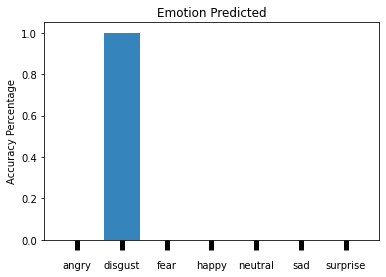

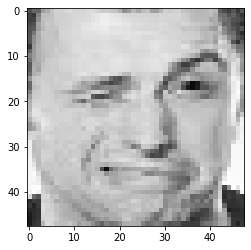

Expression Prediction: disgust


In [21]:
doPredict('/content/Test/Disgust/images (43)_face.png')

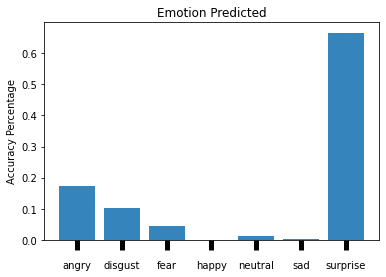

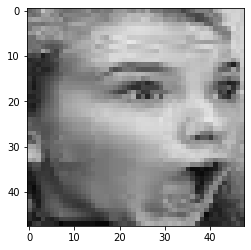

Expression Prediction: surprise


In [22]:
doPredict('/content/Test/Surprise/images - 2020-11-06T202955.094_face.png')